# 下载图像

In [ ]:
!wget https://github.com/egdw/opencv_lesson/blob/test/data/%E5%B7%A5%E4%B8%9A/data/real/img.png?raw=true
!wget https://github.com/egdw/opencv_lesson/blob/test/data/%E5%B7%A5%E4%B8%9A/data/real/img_1.png?raw=true
!wget https://github.com/egdw/opencv_lesson/blob/test/data/%E5%B7%A5%E4%B8%9A/data/real/img_2.png?raw=true
!wget https://github.com/egdw/opencv_lesson/blob/test/data/%E5%B7%A5%E4%B8%9A/data/real/img_3.png?raw=true
!wget https://github.com/egdw/opencv_lesson/blob/test/data/%E5%B7%A5%E4%B8%9A/data/real/img_4.png?raw=true

In [357]:
import cv2 as cv
from google.colab.patches import cv2_imshow as imshow
import numpy as np

# 传入矩阵四个坐标，分别返回左上、右上、左下，右下坐标
def return_rect_position(positions):
  positions = np.array(positions)
  x_min = np.min(positions[:,0])
  x_avg = np.average(positions[:,0])
  x_max = np.max(positions[:,0])
  y_min = np.min(positions[:,1])
  y_avg = np.average(positions[:,1])
  y_max = np.max(positions[:,1])
  print(positions[:,1])
  print(x_min,x_max,y_min,y_max)
  left_top = None
  right_top = None
  left_bottem = None
  right_bottem = None
  for position in positions:
    if position[1] < y_avg:
      # 说明在上方
      if position[0] <x_avg:
        left_top = position
      else:
        right_top = position
    else:
      # 说明在下方
      if position[0] < x_avg:
        left_bottem = position
      else:
        right_bottem = position

  return left_top,right_top,left_bottem,right_bottem


arr = [[ 18.987633,118.311195],[ 20.,10.999995]
 ,[ 96.73844,11.723946]
 ,[ 95.726074,119.03515 ]]
print(return_rect_position(arr))

[118.311195  10.999995  11.723946 119.03515 ]
18.987633 96.73844 10.999995 119.03515
(array([20.      , 10.999995]), array([96.73844 , 11.723946]), array([ 18.987633, 118.311195]), array([ 95.726074, 119.03515 ]))


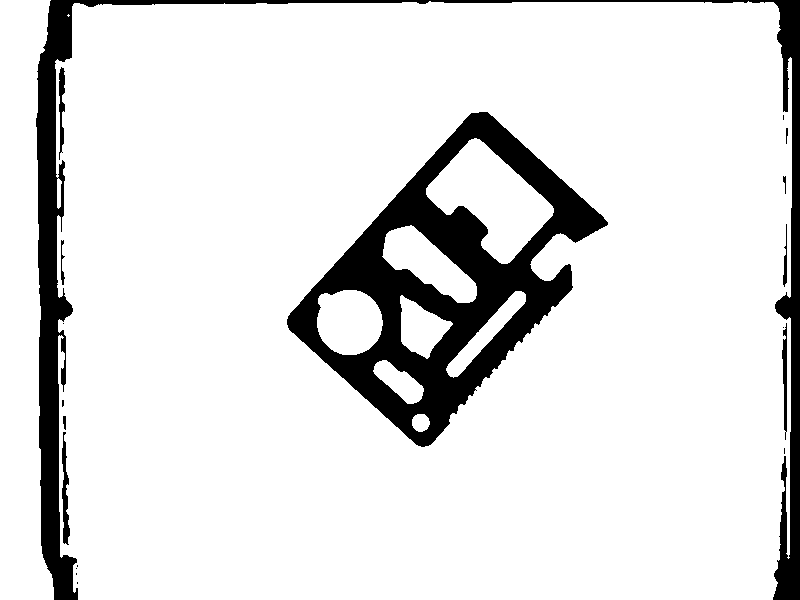

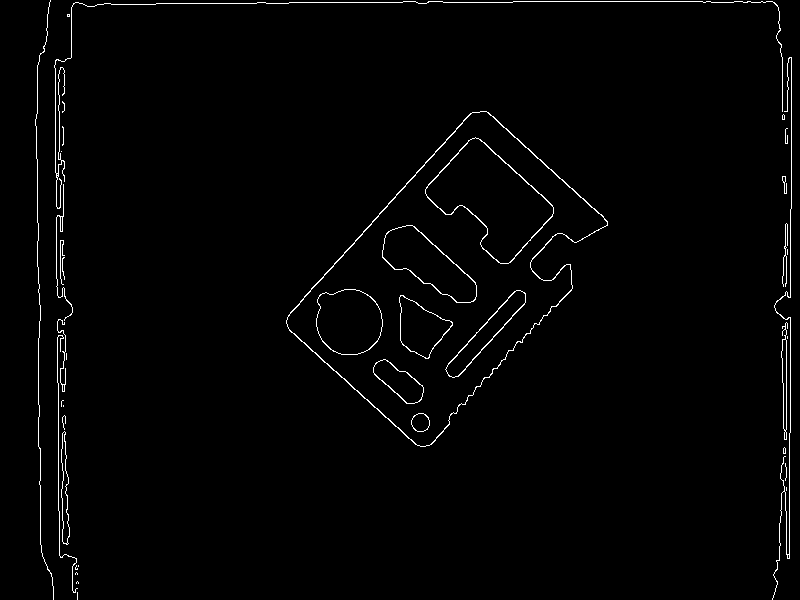

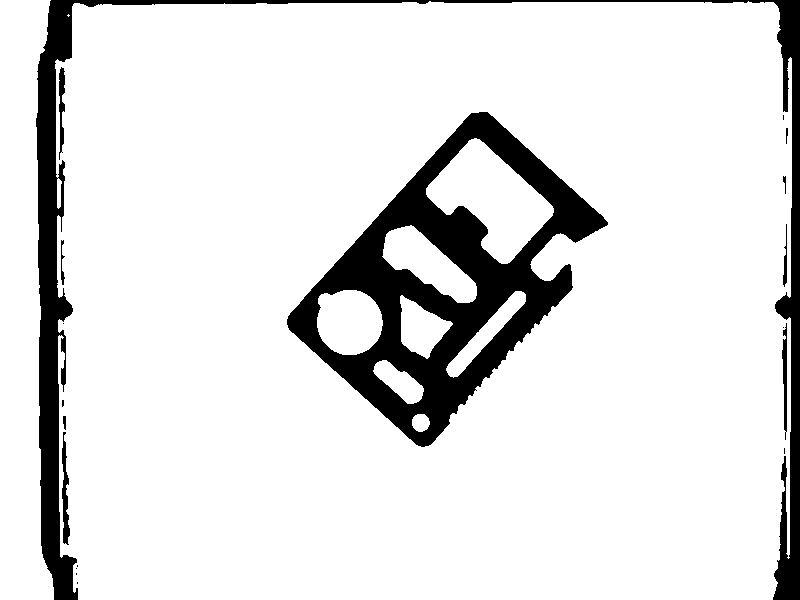

In [506]:
img = cv.imread("img_2.png?raw=true")
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
# gray = cv.equalizeHist(gray) # 直方图均衡化，使得对比度增强。
# dilate_img = cv.dilate(gray, (5, 5), iterations=15)
# erode_img = cv.erode(dilate_img, (3, 3), iterations=3)
# imshow(dilate_img)
threshold = cv.adaptiveThreshold(gray,255,cv.ADAPTIVE_THRESH_MEAN_C ,cv.THRESH_BINARY, 41, 6) # 自适应阈值，主要解决各种光线和亮度问题
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (3, 3))
# threshold = cv.dilate(threshold, kernel,30)
threshold = cv.morphologyEx(threshold, cv.MORPH_OPEN, kernel)
# threshold = cv.morphologyEx(threshold, cv.MORPH_OPEN, kernel)
# threshold = cv.morphologyEx(threshold, cv.MORPH_OPEN, kernel)

backtorgb = cv.cvtColor(threshold,cv.COLOR_GRAY2RGB) # 将阈值后的数据转回三通道图片
bin = cv.Canny(threshold, 0, 100, apertureSize=3) # 边缘算法

imshow(threshold)
imshow(bin)
imshow(backtorgb)

# 定位零件整体位置，并对其进行自动调整分布

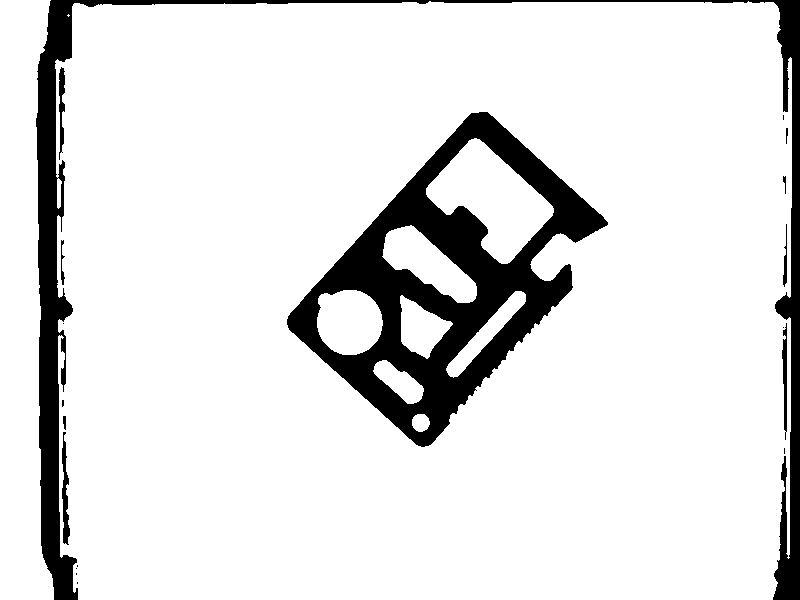

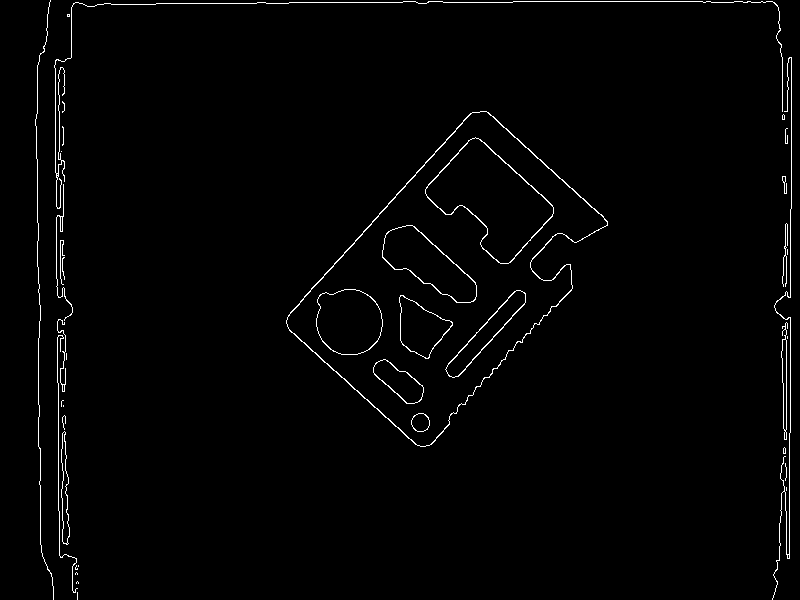

185 290


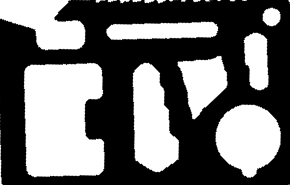

In [508]:
img = cv.imread("img_2.png?raw=true")
img_width = img.shape[0]
img_height = img.shape[1]

# 灰度化
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
threshold = cv.adaptiveThreshold(gray,255,cv.ADAPTIVE_THRESH_MEAN_C ,cv.THRESH_BINARY, 41, 6) # 自适应阈值，主要解决各种光线和亮度问题
# 开运算
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (3, 3))
threshold = cv.morphologyEx(threshold, cv.MORPH_OPEN, kernel)


img = cv.cvtColor(threshold,cv.COLOR_GRAY2BGR) # 将阈值后的数据转回三通道图片

imshow(img)
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)


# sobel 算法，提取矩阵轮廓
# img_blur = cv.GaussianBlur(threshold, (5, 5), 0)
bin = cv.Canny(gray, 0, 100, apertureSize=3)

imshow(bin)

# 找到外部的矩形
contoures, _ = cv.findContours(bin, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
rect_locations = None
for cnt in contoures:
  cnt_len = cv.arcLength(cnt, True)  # 计算轮廓周长
  cnt = cv.approxPolyDP(cnt, 0.02 * cnt_len, True)  # 多边形逼近
  # if cv.contourArea(cnt) > 1000 and cv.isContourConvex(cnt):
  # print(cv.contourArea(cnt))
  if cv.contourArea(cnt) > 40000:
      cnt = cv.minAreaRect(cnt)
      data = np.array(cv.boxPoints(cnt), int)
      cnt = cv.boxPoints(cnt)
      rect_locations = cnt
      # cv.circle(img, data[0], radius=20, color=(255, 255, 0), thickness=10)
      # cv.circle(img, data[1], radius=20, color=(255, 255, 0), thickness=10)
      # cv.circle(img, data[2], radius=20, color=(255, 255, 0), thickness=10)
      # cv.circle(img, data[3], radius=20, color=(255, 255, 0), thickness=10)
      break

# 透视变换
# 判断图片的长宽比，对齐进行自动调整。
if rect_locations is None:
    # 尝试对图片进行旋转
    rows, cols, channels = img.shape
    rotate = cv.getRotationMatrix2D((rows*0.5, cols*0.5), 45, 1)
    img = cv.warpAffine(img, rotate, (cols, rows))
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

    gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    gray = cv.adaptiveThreshold(gray,255,cv.ADAPTIVE_THRESH_MEAN_C ,cv.THRESH_BINARY, 41, 6)
    # sobel 算法，提取矩阵轮廓
    img_blur = cv.GaussianBlur(gray, (5, 5), 0)
    bin = cv.Canny(img_blur, 0, 100, apertureSize=3)
    imshow(img)
    print("查找失败！尝试对图片进行旋转，在进行尝试。")
    # 找到外部的矩形
    contoures, _ = cv.findContours(bin, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    rect_locations = None
    for cnt in contoures:
      cnt_len = cv.arcLength(cnt, True)  # 计算轮廓周长
      cnt = cv.approxPolyDP(cnt, 0.02 * cnt_len, True)  # 多边形逼近
      # if cv.contourArea(cnt) > 1000 and cv.isContourConvex(cnt):
      # print(cv.contourArea(cnt))
      if cv.contourArea(cnt) > 40000:
          cnt = cv.minAreaRect(cnt)
          data = np.array(cv.boxPoints(cnt), int)
          cnt = cv.boxPoints(cnt)
          rect_locations = cnt
          # cv.circle(img, data[0], radius=20, color=(255, 255, 0), thickness=10)
          # cv.circle(img, data[1], radius=20, color=(255, 255, 0), thickness=10)
          # cv.circle(img, data[2], radius=20, color=(255, 255, 0), thickness=10)
          # cv.circle(img, data[3], radius=20, color=(255, 255, 0), thickness=10)
          break
    if rect_locations is None:
      print("查找失败")
    else:
      print("查找成功")
      box_width = int(np.sqrt(
        (rect_locations[1][0] - rect_locations[2][0]) ** 2 + (rect_locations[1][1] - rect_locations[2][1]) ** 2))
      box_height = int(np.sqrt(
          (rect_locations[1][0] - rect_locations[0][0]) ** 2 + (rect_locations[1][1] - rect_locations[0][1]) ** 2))
      print(box_width, box_height)
      perspectiveTransform = cv.getPerspectiveTransform(
          np.float32([rect_locations[1], rect_locations[2], rect_locations[0], rect_locations[3]]).squeeze()
          , np.float32([[0, 0],
                        [box_width, 0],
                        [0, box_height],
                        [box_width, box_height]]))
      warped = cv.warpPerspective(img, perspectiveTransform, (box_width, box_height))
      if box_width < box_height:  # 说明是竖着的
          # 进行转置。
          warped = cv.rotate(warped, cv.ROTATE_90_COUNTERCLOCKWISE)
else:
    box_width = int(np.sqrt(
        (rect_locations[1][0] - rect_locations[2][0]) ** 2 + (rect_locations[1][1] - rect_locations[2][1]) ** 2))
    box_height = int(np.sqrt(
        (rect_locations[1][0] - rect_locations[0][0]) ** 2 + (rect_locations[1][1] - rect_locations[0][1]) ** 2))
    print(box_width, box_height)
    perspectiveTransform = cv.getPerspectiveTransform(
        np.float32([rect_locations[1], rect_locations[2], rect_locations[0], rect_locations[3]]).squeeze()
        , np.float32([[0, 0],
                      [box_width, 0],
                      [0, box_height],
                      [box_width, box_height]]))
    warped = cv.warpPerspective(img, perspectiveTransform, (box_width, box_height))
    if box_width < box_height:  # 说明是竖着的
        # 进行旋转。
        warped = cv.rotate(warped, cv.ROTATE_90_COUNTERCLOCKWISE)

origin_wapred = warped
imshow(warped)

# 找到大圆、小圆的位置，并且使得小圆总是出现在右下角

这里实现的思路其实就是对小圆位置定位后，通过旋转或者图像翻转实现使得小圆始终处右下角

找到的大圆坐标 [249.   45.   33.8]  找到的小圆坐标 [271.5 167.5   8. ]


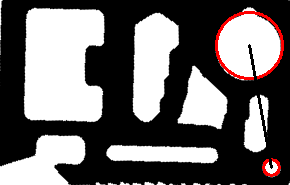

In [509]:
# 找小圆，确定当前的位置
warped = origin_wapred.copy()
# warped_gray = cv.cvtColor(warped, cv.COLOR_BGR2GRAY)
# warped_gray = cv.adaptiveThreshold(warped_gray,255,cv.ADAPTIVE_THRESH_MEAN_C ,cv.THRESH_BINARY, 41, 6)

canny = cv.Canny(warped, 30, 100, apertureSize=3)

# 霍夫找圆

# 找到小圆，定位当前图片位置
circles = cv.HoughCircles(canny, method=cv.HOUGH_GRADIENT, dp=1, minDist=100
                          , param1=30, param2=20, minRadius=1, maxRadius=20)

small_circle = None
for circle in circles[0]:
    # cv.circle(warped, (int(circle[0]), int(circle[1])), radius=int(circle[2]), color=(255, 255, 0), thickness=2)
    small_circle = circle
    break
# 以小圆作为标志物，对图片进行旋转，使得小圆总是出现在右下角
warped_width = warped.shape[0]
warped_height = warped.shape[1]
if small_circle[0] < warped_width / 2 and small_circle[1] < warped_height / 2:
    # 当前小圆处于左上，旋转180
    warped = cv.rotate(warped, cv.ROTATE_180)
    canny = cv.rotate(canny, cv.ROTATE_180)
elif small_circle[0] < warped_width / 2 and small_circle[1] > warped_height / 2:
    # 说明在左下需要进行水平flib
    warped = cv.flip(warped, 1)  # 水平翻转
    canny = cv.flip(canny, 1)  # 水平翻转

elif small_circle[0] > warped_width / 2 and small_circle[1] < warped_height / 2:
    # 说明在右上，需要进行垂直翻转
    warped = cv.flip(warped, 0)
    canny = cv.flip(canny, 0)


# 再找一次经过调整后的小圆位置
circles = cv.HoughCircles(canny, method=cv.HOUGH_GRADIENT, dp=1, minDist=100
                          , param1=30, param2=20, minRadius=1, maxRadius=20)
for circle in circles[0]:
    cv.circle(warped, (int(circle[0]), int(circle[1])), radius=int(circle[2]), color=(0, 0, 255), thickness=2)
    small_circle = circle
    break

# 找到大圆
circles = cv.HoughCircles(canny, method=cv.HOUGH_GRADIENT, dp=2, minDist=20
                          , param1=90, param2=90, minRadius=1, maxRadius=80)
# print(circles)
big_circle = None
for circle in circles[0]:
    cv.circle(warped, (int(circle[0]), int(circle[1])), radius=int(circle[2]), color=(0, 0, 255), thickness=2)
    big_circle = circle
    break

print("找到的大圆坐标", big_circle, " 找到的小圆坐标", small_circle)
# 画出两个圆之间的距离,即a
cv.line(warped,(int(big_circle[0]),int(big_circle[1])),(int(small_circle[0]),int(small_circle[1])),color=(0,0,0),thickness=2)

imshow(warped)

[20.810095   4.8247705  8.220182  24.205507 ]
1.7330246 114.26606 4.8247705 24.205507
矩形宽高： 112 15
e: 97


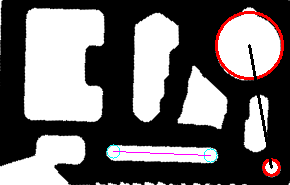

In [510]:
# warped = origin_wapred
# 求长条圆柱
warped_cycle = warped[warped_width-warped_width//4:warped_width-warped_width//10, warped_height//2-warped_height//7:warped_height//2+warped_height//3].copy()
warped_cycle_canny = cv.Canny(warped_cycle, 30, 100, apertureSize=3)
imshow(warped_cycle_canny)
# 求e
contoures, _ = cv.findContours(warped_cycle_canny, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
for cnt in contoures:
    cnt_len = cv.arcLength(cnt, True)  # 计算轮廓周长
    cnt = cv.approxPolyDP(cnt, 0.02 * cnt_len, True)  # 多边形逼近
    # print(cv.contourArea(cnt))
    if cv.contourArea(cnt) > 200:
        # print(cv.contourArea(cnt))
        cnt = cv.minAreaRect(cnt)
        data = np.array(cv.boxPoints(cnt), int)
        cnt = cv.boxPoints(cnt)
        box_height = int(np.sqrt(
            (cnt[1][0] - cnt[0][0]) ** 2 + (
                    cnt[1][1] - cnt[0][1]) ** 2))
        box_width = int(np.sqrt(
            (cnt[1][0] - cnt[2][0]) ** 2 + (
                    cnt[1][1] - cnt[2][1]) ** 2))
        # if box_width > box_height:
        #   # 说明需要互换
        #   temp = box_width
        #   box_width = box_height
        #   box_height = temp
        left_top,right_top,left_bottem,right_bottem = return_rect_position(cnt)
        if box_height < box_width:
          temp = box_height
          box_height = box_width
          box_width = temp
        print("矩形宽高：",box_height,box_width)

        # 得到左圆
        left_circle_center = (int(left_top[0]+box_width/2),int(left_top[1]+box_width/2))
        # print("warped_cycle_canny:",left_circle_center)
        # cv.circle(warped_cycle_canny, left_circle_center, radius=int(box_width/2), color=(255, 255, 0), thickness=1)
        cv.circle(warped, (warped_height//2-warped_height//7+left_circle_center[0],warped_width-warped_width//4+left_circle_center[1]), radius=int(box_width/2), color=(255, 255, 0), thickness=1)

        # 得到右圆
        right_circle_center = (int(right_bottem[0] - box_width / 2), int(right_bottem[1] - box_width / 2))
        # print("warped_cycle_canny:", right_circle_center)
        # cv.circle(warped_cycle_canny, right_circle_center, radius=int(box_width/2), color=(0, 255, 255), thickness=1)
        cv.circle(warped, (warped_height//2-warped_height//7+right_circle_center[0],warped_width-warped_width//4+right_circle_center[1]), radius=int(box_width/2), color=(255, 255, 0), thickness=1)


        cv.line(warped,(warped_height//2-warped_height//7+left_circle_center[0],warped_width-warped_width//4+left_circle_center[1]),
                (warped_height//2-warped_height//7+right_circle_center[0],warped_width-warped_width//4+right_circle_center[1]),
                color=(255, 0, 255),thickness=1)
        print("e:",box_height-box_width)
        # print(cnt[1][0] ,cnt[0][0])
        # # 得到居中的位置
        # center_point = (int(cnt[1][0] + cnt[0][0]) // 2, int(cnt[1][1] + cnt[0][1]) // 2)
        # print(box_height,box_width)
        # # cv.circle(warped, (warped_height//2-warped_height//7+center_point[0],center_point[1]), radius=10, color=(255, 255, 0), thickness=1)
        # cv.line(warped, (warped_height // 2 - warped_height // 7 + center_point[0], 0),
        #         (warped_height // 2 - warped_height // 7 + center_point[0], center_point[1]), color=(255, 0, 255),
        #         thickness=1)
        # print("b:", center_point[1])
        break
imshow(warped)

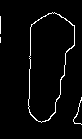

10.5
0.0
0.0
3426.0
矩形宽高： 44 110
[121.67068   11.416908  12.513634 122.7674  ]
27.662453 74.80213 11.416908 122.7674
b: 11


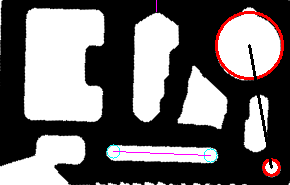

In [511]:
# 长得像钥匙。
warped_key = warped[0:warped_width-warped_width//4, warped_height//2-warped_height//7:warped_height//2+warped_height//7].copy()
warped_key_canny = cv.Canny(warped_key, 30, 100, apertureSize=3)
imshow(warped_key_canny)
# 求上下高度b
contoures, _ = cv.findContours(warped_key_canny, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
for cnt in contoures:
    cnt_len = cv.arcLength(cnt, True)  # 计算轮廓周长
    cnt = cv.approxPolyDP(cnt, 0.02 * cnt_len, True)  # 多边形逼近
    print(cv.contourArea(cnt))
    if cv.contourArea(cnt) > 1000:
        cnt = cv.minAreaRect(cnt)
        data = np.array(cv.boxPoints(cnt), int)
        cnt = cv.boxPoints(cnt)
        box_height = int(np.sqrt(
            (cnt[1][0] - cnt[0][0]) ** 2 + (
                        cnt[1][1] - cnt[0][1]) ** 2))
        box_width = int(np.sqrt(
            (cnt[1][0] - cnt[2][0]) ** 2 + (
                        cnt[1][1] - cnt[2][1]) ** 2))
        if box_height > box_width:
          temp = box_height
          box_height = box_width
          box_width = temp
        print("矩形宽高：",box_height,box_width)
        left_top,right_top,left_bottem,right_bottem = return_rect_position(cnt)
        # 得到居中的位置,这里还是要判断那边是右边。
        center_point = (int(right_top[0] + left_top[0])//2,int(left_top[1] + right_top[1])//2)
        # print(center_point)
        # cv.circle(warped, (warped_height//2-warped_height//7+center_point[0],center_point[1]), radius=10, color=(255, 255, 0), thickness=1)
        cv.line(warped,(warped_height//2-warped_height//7+center_point[0],0),(warped_height//2-warped_height//7+center_point[0],center_point[1]),color=(255,0,255),thickness=1)
        print("b:",center_point[1])
        break
imshow(warped)

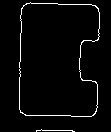

0.0
7331.0
410.02438485622406
矩形宽高： 75 109
[112.          2.9999967   7.141144  116.14114  ]
20.0 101.23076 2.9999967 116.14114
[23. 57.]
c: 54.135788


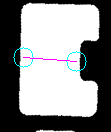

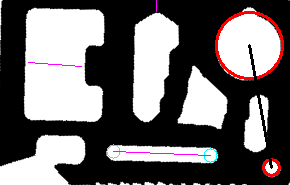

In [512]:

# 
warped_left = warped[5:137, 5:116].copy()
gray = cv.cvtColor(warped_left, cv.COLOR_BGR2GRAY)
warped_left_canny = cv.Canny(gray, 30, 100, apertureSize=3)
# gray =cv.adaptiveThreshold(gray,255,cv.ADAPTIVE_THRESH_MEAN_C ,cv.THRESH_BINARY, 41, 6)
imshow(warped_left_canny)

contoures, _ = cv.findContours(warped_left_canny, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
for cnt in contoures:
    cnt_len = cv.arcLength(cnt, True)  # 计算轮廓周长
    cnt = cv.approxPolyDP(cnt, 0.02 * cnt_len, True)  # 多边形逼近
    print(cv.contourArea(cnt))
    if cv.contourArea(cnt) > 5000:
        cnt = cv.minAreaRect(cnt)
        print(cnt_len)
        data = np.array(cv.boxPoints(cnt), int)
        cnt = cv.boxPoints(cnt)
        box_height = int(np.sqrt(
            (cnt[1][0] - cnt[0][0]) ** 2 + (
                        cnt[1][1] - cnt[0][1]) ** 2))
        box_width = int(np.sqrt(
            (cnt[1][0] - cnt[2][0]) ** 2 + (
                        cnt[1][1] - cnt[2][1]) ** 2))
        
        if box_height > box_width:
          temp = box_height
          box_height = box_width
          box_width = temp
        print("矩形宽高：",box_height,box_width)

        # print(box_height,box_width,cnt,cnt.shape)
        left_top,right_top,left_bottem,right_bottem = return_rect_position(cnt)
        # 得到居中的位置,这里还是要判断那边是右边。
        left_center_point = (left_top+left_bottem)//2
        print(left_center_point)
        right_center_point = ((right_top+right_bottem)//2)
        right_center_point[0] = right_center_point[0]-((cnt_len - 2*box_height - 2*box_width)/2)

        cv.circle(warped_left,[int(left_center_point[0]),int(left_center_point[1])] , radius=10, color=(255, 255, 0), thickness=1)
        cv.circle(warped_left,[int(right_center_point[0]),int(right_center_point[1])] , radius=10, color=(255, 255, 0), thickness=1)
        cv.line(warped_left,[int(left_center_point[0]),int(left_center_point[1])],[int(right_center_point[0]),int(right_center_point[1])],color=(255,0,255),thickness=1)
        print("c:",np.sqrt(np.sum((left_center_point-right_center_point)**2)))
        cv.line(warped,[5+int(left_center_point[0]),5+int(left_center_point[1])],[5+int(right_center_point[0]),5+int(right_center_point[1])],color=(255,0,255),thickness=1)
        break
imshow(warped_left)
imshow(warped)

先分别求取线斜率K1，K2，然后带进公式计算角度。
假设k1为垂直直线，则k1恒等于0
则angle = atan(k2) * 180 / PI
k = (k2 - k1) / (1 + k1*k2);
angle = atan(k) * 180 / PI;



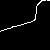

(5, 37) (23, 25)
计算的斜率为： -0.6666666666666666
角度为： 56.309932474020215


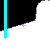

In [513]:

# 
warped_bottem = warped[-50:, :50].copy()
gray = cv.cvtColor(warped_bottem, cv.COLOR_BGR2GRAY)
warped_bottem_canny = cv.Canny(gray, 30, 100, apertureSize=3)
# gray =cv.adaptiveThreshold(gray,255,cv.ADAPTIVE_THRESH_MEAN_C ,cv.THRESH_BINARY, 41, 6)
imshow(warped_bottem_canny)

# lines = cv.HoughLinesP(warped_bottem_canny,1, np.pi / 180, 1, 100, 2)
# print(lines)

left_point = None
right_point = None

for y in range(50):
  cv.circle(warped_bottem,(5,y) , radius=1, color=(255, 255, 0), thickness=1)
  if warped_bottem_canny[5][y] > 200:
    left_point = (5,y)
    break

for x in range(50):
  if warped_bottem_canny[49-x][25] == 255:
    right_point = (49-x,25)
    break

print(left_point,right_point)
k = (right_point[1] - left_point[1])/(right_point[0] - left_point[0])
print("计算的斜率为：",k)
print("角度为：",90-abs(np.arctan(k)*180/np.pi))
cv.circle(warped_bottem,left_point , radius=1, color=(255, 255, 0), thickness=1)
cv.circle(warped_bottem,right_point , radius=1, color=(255, 255, 0), thickness=1)

# for line in lines:
#   cv.line(warped_bottem,[line[0][0],line[0][1]],[line[0][2],line[0][3]],color=(255,0,255),thickness=1)

imshow(warped_bottem)